In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import match_coordinates_sky
from tqdm.notebook import tqdm
from collections import Counter
import healpy as hp

In [3]:
waves_s_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_s_ultralite.parquet'
waves_n_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_n_ultralite.parquet'

In [4]:
cat = pq.read_table(waves_s_filepath).to_pandas()
#cat.loc[cat['starmask'] == 1, 'class'] = 'star'
cat = cat[(cat['duplicate']==0)]

In [5]:
len(cat)

51472028

In [6]:
stars_path = '/Users/sp624AA/Downloads/Masking/gaiastarmaskwaves.csv'

In [7]:
stars = pd.read_csv(stars_path)

In [8]:
stars = stars[(stars['dec'] < -10) & (stars['phot_g_mean_mag'] <= 16)]

In [9]:
def mask_radius_waves(g):
    """
    Calculate r[arcmin] based on the given formula.

    Parameters:
        g (float or array-like): Input magnitude.

    Returns:
        numpy.ndarray: Calculated r[arcmin].
    """
    g = np.asarray(g)  # Ensure g is a NumPy array
    r = np.zeros_like(g, dtype=float)
    mask1 = (g > 3.5) & (g < 16)
    mask2 = g <= 3.5
    r[mask1] = (10 ** (1.3 - 0.13 * g[mask1])) 
    r[mask2] = 7 
    return r

In [10]:
stars['mask_radius'] = mask_radius_waves(stars['phot_g_mean_mag'])

In [11]:
sel = (stars['phot_g_mean_mag'] > 0) & (stars['phot_g_mean_mag'] < 8)

#stars = stars[stars['phot_g_mean_mag'] <= 8]
stars = stars[sel]

In [12]:
min(stars['mask_radius'])

1.8203801907589197

In [13]:

# Input arrays
stars_coords = SkyCoord(ra=np.array(stars['ra'])*u.deg, dec=np.array(stars['dec'])*u.deg)
sources_coords = SkyCoord(ra=np.array(cat['RAmax'])*u.deg, dec=np.array(cat['Decmax'])*u.deg)


In [25]:
nside = 1024 * 32
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"NSIDE = {nside}, resolution ≈ {res_arcmin:.2f} arcmin")

# Define the small region: RA 330°–51.6°, Dec −35.6° to −27.0°
ra_min, ra_max = np.radians([330.0, 411.6])  # RA wraps at 360
dec_min, dec_max = np.radians([-35.6, -27.0])

# Get pixel indices in this region using polygon
polygon = np.array([
    [ra_min, dec_min],
    [ra_max, dec_min],
    [ra_max, dec_max],
    [ra_min, dec_max]
])
vecs = hp.ang2vec(np.pi/2 - polygon[:, 1], polygon[:, 0])
region_pix = hp.query_polygon(nside, vecs)
region_pix_set = set(region_pix)

# Get HEALPix pixels of sources
ra_rad = sources_coords.ra.rad
dec_rad = sources_coords.dec.rad
ipix_sources = hp.ang2pix(nside, 0.5 * np.pi - dec_rad, ra_rad)

# Keep only those sources within the region
mask = np.isin(ipix_sources, region_pix)
ipix_sources = ipix_sources[mask]

# Build sparse density map: only counts in covered region
density_map = Counter(ipix_sources)

# Radii (arcmin)
radii = np.array(stars['mask_radius'])
print(f"Minimum radius of star in sample is {min(radii):.2f} arcmin")

# Histogram setup
extent = 3
nbins = int(np.floor(extent * min(radii) / res_arcmin))
print('n bins:', nbins)

query_extent = 5  # in units of R
rad_to_arcmin = 180/np.pi * 60  # ≈ 3437.75

stacked = np.zeros((nbins, nbins), dtype=np.float32)
xedges = np.linspace(-extent, extent, nbins + 1)
yedges = np.linspace(-extent, extent, nbins + 1)

# Build reverse pixel index for fast lookup
for i in tqdm(range(len(stars))):
    ra0 = stars_coords.ra.rad[i]
    dec0 = stars_coords.dec.rad[i]
    R_arcmin = radii[i]
    R_deg = R_arcmin * query_extent / 60.0

    vec = hp.ang2vec(0.5 * np.pi - dec0, ra0)
    ipix_disc = hp.query_disc(nside, vec, np.radians(R_deg), inclusive=True)

    for ipix in ipix_disc:
        if ipix not in density_map:
            continue  # skip empty pixels

        theta, phi = hp.pix2ang(nside, ipix)
        ra_pix = phi
        dec_pix = 0.5 * np.pi - theta

        dra = (ra_pix - ra0) * np.cos(dec0)
        ddec = dec_pix - dec0

        x = (dra * rad_to_arcmin) / R_arcmin
        y = (ddec * rad_to_arcmin) / R_arcmin

        if abs(x) < extent and abs(y) < extent:
            ix = np.searchsorted(xedges, x) - 1
            iy = np.searchsorted(yedges, y) - 1
            if 0 <= ix < nbins and 0 <= iy < nbins:
                stacked[iy, ix] += density_map[ipix]


NSIDE = 32768, resolution ≈ 0.11 arcmin
Minimum radius of star in sample is 1.82 arcmin
n bins: 50


  0%|          | 0/854 [00:00<?, ?it/s]

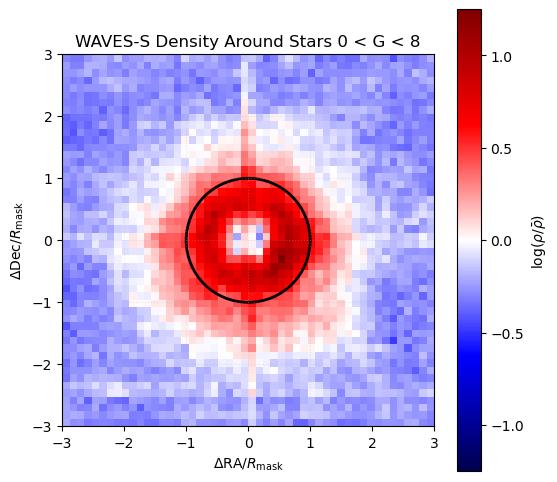

In [26]:
#import matplotlib.pyplot as plt
#from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(figsize=(6, 6))

# Convert edges to bin centers for plotting (optional)
Xc = 0.5 * (xedges[:-1] + xedges[1:])
Yc = 0.5 * (yedges[:-1] + yedges[1:])
XX, YY = np.meshgrid(Xc, Yc)

log_density = np.log(stacked / np.mean(stacked))
vmax = np.max(np.abs(log_density))  # symmetric range around 0

pcm = ax.pcolormesh(
    xedges, yedges, log_density,
    cmap='seismic',
    shading='auto',
    vmin=-vmax, vmax=vmax  # symmetric color range
)

ax.set_xlabel(r'$\Delta \mathrm{RA} / R_{\mathrm{mask}}$')
ax.set_ylabel(r'$\Delta \mathrm{Dec} / R_{\mathrm{mask}}$')
ax.set_title('WAVES-S Density Around Stars 0 < G < 8')
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)
ax.set_aspect('equal')
# Create a circle with radius 1 centered at (x, y) = (2, 2)
circle = patches.Circle((0, 0), 1, fill=False, color='black', linewidth=2)

# Add the circle to the axis
ax.add_patch(circle)
# Colorbar
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label(r'$\log(\rho/\bar{\rho})$')

plt.grid(alpha=0.3, linestyle=':')
plt.savefig('waves-s-all-0<g<8')
plt.show()



In [31]:
def mask_radius_waves(g):
    """
    Calculate r[arcmin] based on the given formula.

    Parameters:
        g (float or array-like): Input magnitude.

    Returns:
        numpy.ndarray: Calculated r[arcmin].
    """
    g = np.asarray(g)  # Ensure g is a NumPy array
    r = np.zeros_like(g, dtype=float)
    mask1 = (g > 3.5) & (g < 16)
    mask2 = g <= 3.5
    r[mask1] = (10 ** (1.3 - 0.13 * g[mask1])) 
    r[mask2] = 7 
    return r


class star_overdensites:
    def __init__(self, waves_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_s_ultralite.parquet', 
                 gaiastar_filepath = '/Users/sp624AA/Downloads/Masking/gaiastarmaskwaves.csv', 
                 waves_region ='S', 
                 gaia_g_bins = [[0, 8], [8, 13], [13, 15], [15,16]]):
        

        self.waves_filepath = waves_filepath
        self.gaiastar_filepath = gaiastar_filepath
        self.waves_region = waves_region
        if self.waves_region not in ['N', 'S']:
            print('waves_region must be either N or S')
            raise ValueError
        

        self.gaia_bins = gaia_g_bins
        
        self.bin_names = []
        for i in range(len(self.gaia_bins)):
            self.bin_names.append(str(self.gaia_bins[i][0]) + "<" + str(self.gaia_bins[i][1]))

        print(f'bin names: {self.bin_names}')

        self.stacks = {}


        if self.waves_region == 'S':
                        # Define the small region: RA 330°–51.6°, Dec −35.6° to −27.0°
            ra_min, ra_max = np.radians([330.0, 411.6])  # RA wraps at 360
            dec_min, dec_max = np.radians([-35.6, -27.0])

        if self.waves_region == 'N':
            ra_min, ra_max = np.radians([157.25, 225.])  # RA wraps at 360
            dec_min, dec_max = np.radians([-3.95, 3.95])
            

        # Get pixel indices in this region using polygon
        self.polygon = np.array([
            [ra_min, dec_min],
            [ra_max, dec_min],
            [ra_max, dec_max],
            [ra_min, dec_max]
        ])

        


    def load_waves(self):
        self.cat = pq.read_table(self.waves_filepath).to_pandas()
        #cat.loc[cat['starmask'] == 1, 'class'] = 'star'
        self.cat = self.cat[(self.cat['duplicate']==0)]

    def load_gaia_stars(self):
        self.all_stars = pd.read_csv(self.gaiastar_filepath)
        self.all_stars = self.all_stars[self.all_stars['phot_g_mean_mag'] <= 16]
        if self.waves_region == 'S':
            self.all_stars = self.all_stars[self.all_stars['dec'] < -10]
        else:
            self.all_stars = self.all_stars[self.all_stars['dec'] > -10]
        self.all_stars['mask_radius'] = mask_radius_waves(self.all_stars['phot_g_mean_mag'])


    def get_stacks(self):

        for gbin in range(len(self.bin_names)):


            sel = (self.all_stars['phot_g_mean_mag'] > self.gaia_bins[gbin][0]) & (self.all_stars['phot_g_mean_mag'] <= self.gaia_bins[gbin][1])

            #stars = stars[stars['phot_g_mean_mag'] <= 8]
            stars = self.all_stars[sel]


            # Input arrays
            stars_coords = SkyCoord(ra=np.array(stars['ra'])*u.deg, dec=np.array(stars['dec'])*u.deg)
            sources_coords = SkyCoord(ra=np.array(self.cat['RAmax'])*u.deg, dec=np.array(self.cat['Decmax'])*u.deg)

            nside = 1024 * 32
            res_arcmin = hp.nside2resol(nside, arcmin=True)
            print(f"NSIDE = {nside}, resolution ≈ {res_arcmin:.2f} arcmin")

            vecs = hp.ang2vec(np.pi/2 - self.polygon[:, 1], self.polygon[:, 0])
            region_pix = hp.query_polygon(nside, vecs)
            region_pix_set = set(region_pix)

            # Get HEALPix pixels of sources
            ra_rad = sources_coords.ra.rad
            dec_rad = sources_coords.dec.rad
            ipix_sources = hp.ang2pix(nside, 0.5 * np.pi - dec_rad, ra_rad)

            # Keep only those sources within the region
            mask = np.isin(ipix_sources, region_pix)
            ipix_sources = ipix_sources[mask]

            # Build sparse density map: only counts in covered region
            density_map = Counter(ipix_sources)

            # Radii (arcmin)
            radii = np.array(stars['mask_radius'])
            print(f"Minimum radius of star in sample is {min(radii):.2f} arcmin")

            # Histogram setup
            extent = 3
            nbins = int(np.floor(extent * min(radii) / res_arcmin))
            print('n bins:', nbins)


            query_extent = 5  # in units of R
            rad_to_arcmin = 180/np.pi * 60  # ≈ 3437.75

            self.stacks[self.bin_names[gbin]] = np.zeros((nbins, nbins), dtype=np.float32)
            xedges = np.linspace(-extent, extent, nbins + 1)
            yedges = np.linspace(-extent, extent, nbins + 1)

            # Build reverse pixel index for fast lookup
            for i in tqdm(range(len(stars))):
                ra0 = stars_coords.ra.rad[i]
                dec0 = stars_coords.dec.rad[i]
                R_arcmin = radii[i]
                R_deg = R_arcmin * query_extent / 60.0

                vec = hp.ang2vec(0.5 * np.pi - dec0, ra0)
                ipix_disc = hp.query_disc(nside, vec, np.radians(R_deg), inclusive=True)

                for ipix in ipix_disc:
                    if ipix not in density_map:
                        continue  # skip empty pixels

                    theta, phi = hp.pix2ang(nside, ipix)
                    ra_pix = phi
                    dec_pix = 0.5 * np.pi - theta

                    dra = (ra_pix - ra0) * np.cos(dec0)
                    ddec = dec_pix - dec0

                    x = (dra * rad_to_arcmin) / R_arcmin
                    y = (ddec * rad_to_arcmin) / R_arcmin

                    if abs(x) < extent and abs(y) < extent:
                        ix = np.searchsorted(xedges, x) - 1
                        iy = np.searchsorted(yedges, y) - 1
                        if 0 <= ix < nbins and 0 <= iy < nbins:
                            self.stacks[self.bin_names[gbin]][iy, ix] += density_map[ipix]


    def plot_stacks(self):
        """
        Plot all stacks in self.stacks as subplots
        """
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        import numpy as np
        
        n_bins = len(self.stacks)
        
        # Create subplots - arrange in a grid
        if n_bins <= 2:
            fig, axes = plt.subplots(1, n_bins, figsize=(6*n_bins, 6))
        elif n_bins <= 4:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        else:
            # For more than 4 bins, arrange in rows of 3
            n_rows = (n_bins + 2) // 3
            fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
        
        # Ensure axes is always a list for consistent indexing
        if n_bins == 1:
            axes = [axes]
        elif n_bins > 1 and hasattr(axes, 'flatten'):
            axes = axes.flatten()
        
        # Calculate extent and edges (same as in get_stacks)
        # We need to recalculate these since they're not stored as class attributes
        if hasattr(self, 'all_stars'):
            radii = np.array(self.all_stars['mask_radius'])
            min_radius = min(radii)
        else:
            # If stars not loaded, use a default
            min_radius = 1.0  # You might want to store this in the class
        
        # Recreate the same parameters used in get_stacks
        nside = 1024 * 32
        res_arcmin = hp.nside2resol(nside, arcmin=True)
        extent = 3
        nbins = int(np.floor(extent * min_radius / res_arcmin))
        
        xedges = np.linspace(-extent, extent, nbins + 1)
        yedges = np.linspace(-extent, extent, nbins + 1)
        
        # Plot each stack
        for i, (bin_name, stacked) in enumerate(self.stacks.items()):
            ax = axes[i]
            
            # Calculate log density
            mean_density = np.mean(stacked[stacked > 0])  # Avoid log(0)
            if mean_density > 0:
                log_density = np.log(stacked / mean_density)
                # Handle -inf values (where stacked == 0)
                log_density[np.isinf(log_density)] = np.min(log_density[~np.isinf(log_density)])
            else:
                log_density = np.zeros_like(stacked)
            
            vmax = np.max(np.abs(log_density))  # symmetric range around 0
            
            pcm = ax.pcolormesh(
                xedges, yedges, log_density,
                cmap='seismic',
                shading='auto',
                vmin=-vmax, vmax=vmax  # symmetric color range
            )
            
            ax.set_xlabel(r'$\Delta \mathrm{RA} / R_{\mathrm{mask}}$')
            ax.set_ylabel(r'$\Delta \mathrm{Dec} / R_{\mathrm{mask}}$')
            ax.set_title(f'WAVES-{self.waves_region} Density Around Stars {bin_name} mag')
            ax.set_xlim(-extent, extent)
            ax.set_ylim(-extent, extent)
            ax.set_aspect('equal')
            
            # Create a circle with radius 1 centered at origin
            circle = patches.Circle((0, 0), 1, fill=False, color='black', linewidth=2)
            ax.add_patch(circle)
            
            # Colorbar for each subplot
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.set_label(r'$\log(\rho/\bar{\rho})$')
            
            ax.grid(alpha=0.3, linestyle=':')
        
        # Hide any unused subplots
        if n_bins < len(axes):
            for j in range(n_bins, len(axes)):
                axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(f'waves-{self.waves_region.lower()}-all-bins-stacks.png', dpi=150, bbox_inches='tight')
        plt.show()



In [34]:
plotter = star_overdensites()

bin names: ['0<8', '8<13', '13<15', '15<16']


In [35]:
plotter.load_waves()
plotter.load_gaia_stars()
plotter.get_stacks()
plotter.plot_stacks()

NSIDE = 32768, resolution ≈ 0.11 arcmin


: 